In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
import cv2
import os
import numpy as np

In [3]:
labels = ['0', '1']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

train = get_data('./Dataset/train')
val = get_data('./Dataset/test')

<ipython-input-3-5761a417b5d4>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data)


Text(0.5, 1.0, '0')

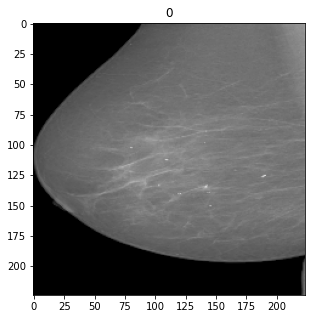

In [3]:
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])

Text(0.5, 1.0, '1')

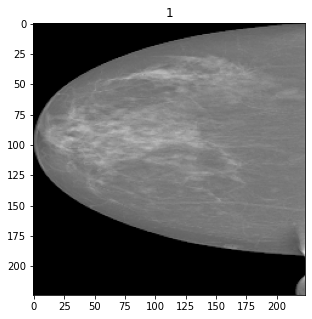

In [4]:
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

In [4]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [5]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [6]:
import sys
from tensorflow.python.keras.models import Sequential,load_model,clone_model
from tensorflow.python.keras.layers import Convolution2D, Activation, MaxPooling2D, Dense, Flatten,Conv2D,Reshape,Dropout, Input
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.python.keras import backend as K
from tensorflow.keras.optimizers import SGD

In [7]:
from keras.engine.topology import Layer
import keras.backend as K
from keras.layers import Flatten



In [14]:

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

BATCH = 64

class SppnetLayer(Layer):
    '''This layer takes an input tensor and pools the tensor
      in local spatial bins.
      This layer uses Max pooling.
      It accepts input in tensorflow format. # channels last

    # Input
        list of filter in form [x,y,z] 
    # Input shape : 4d tensor [None, X,Y, channels]
    # Output shape : 3d tensor [None,pooled dim, channels] 

    '''
    def __init__(self, filters = [1], **kwargs):
        self.filters = filters
        super(SppnetLayer, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        length = 0;
        for f_size in self.filters:
            length+= (f_size*f_size)
        return (input_shape[0],length*input_shape[3])
      
    def get_config(self):
        config = {'filters': self.filters}
        base_config = super(SppnetLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, inputs):
      output = []
      for f_size in self.filters:
        win_size = K.int_shape(inputs)[1]/f_size
        #print(win_size)
        win_size = int(win_size)
        for x_start in range(0,f_size):
          for y_start in range(0,f_size):
            X = int(x_start*win_size)
            Y = int(y_start*win_size)
            result = K.max(inputs[:,X:X+win_size,Y:Y+win_size,:],axis = (1,2))
            output.append(result)
      output = K.concatenate(output)
      return output

    
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

BATCH = 64

class SppnetLayer(Layer):
    '''This layer takes an input tensor and pools the tensor
      in local spatial bins.
      This layer uses Max pooling.
      It accepts input in tensorflow format. # channels last

    # Input
        list of filter in form [x,y,z] 
    # Input shape : 4d tensor [None, X,Y, channels]
    # Output shape : 3d tensor [None,pooled dim, channels] 

    '''
    def __init__(self, filters = [1], **kwargs):
        self.filters = filters
        super(SppnetLayer, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        length = 0;
        for f_size in self.filters:
            length+= (f_size*f_size)
        return (input_shape[0],length*input_shape[3])
      
    def get_config(self):
        config = {'filters': self.filters}
        base_config = super(SppnetLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, inputs):
      output = []
      for f_size in self.filters:
        win_size = K.int_shape(inputs)[1]/f_size
        #print(win_size)
        win_size = int(win_size)
        for x_start in range(0,f_size):
          for y_start in range(0,f_size):
            X = int(x_start*win_size)
            Y = int(y_start*win_size)
            result = K.max(inputs[:,X:X+win_size,Y:Y+win_size,:],axis = (1,2))
            output.append(result)
      output = K.concatenate(output)
      return output

from keras.applications import DenseNet121

base_model = DenseNet121(include_top=False, weights="imagenet",  input_shape=(224,224,3), pooling='max' )
 
for layer in base_model.layers:
    layer.trainable = False
    
model=Sequential()
model.add(base_model)
model.add(SppnetLayer([1,2,4]))
#model.add(SpatialPyramidPooling([1,2,4]))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

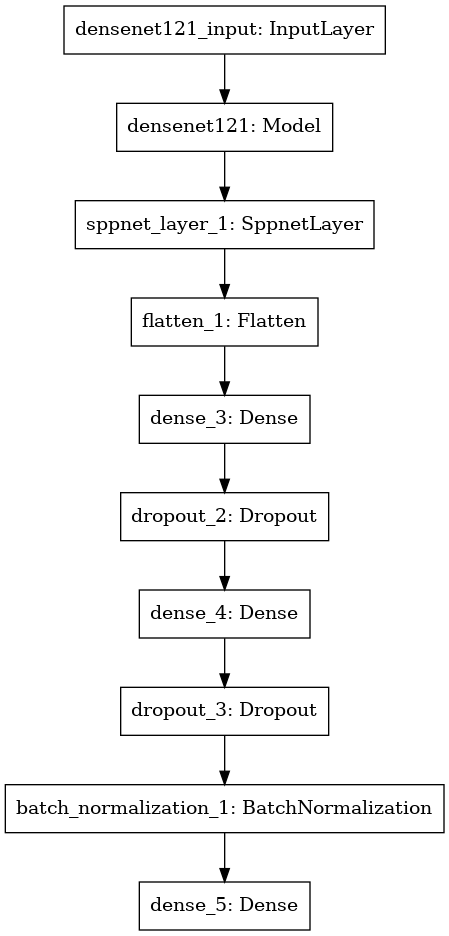

In [15]:
from tensorflow.keras.utils import plot_model

plot_model(model)

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
sppnet_layer_1 (SppnetLayer) (None, 21504)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 21504)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               11010560  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [17]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [18]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer,loss='binary_crossentropy',metrics=["accuracy"])
es = EarlyStopping(monitor='val_loss',mode='min', verbose=1,patience=10)
lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3,verbose=1, factor=0.25, min_lr=0.0001)

In [13]:
history = model.fit(x_train,y_train,epochs = 50 , validation_data = (x_val, y_val))

Epoch 1/50
11/11 [==============================] - 45s 4s/step - loss: nan - accuracy: 0.7354 - val_loss: nan - val_accuracy: 1.0000
Epoch 2/50
11/11 [==============================] - 33s 3s/step - loss: nan - accuracy: 0.7354 - val_loss: nan - val_accuracy: 1.0000
Epoch 3/50
11/11 [==============================] - 36s 3s/step - loss: nan - accuracy: 0.7354 - val_loss: nan - val_accuracy: 1.0000
Epoch 4/50
11/11 [==============================] - 35s 3s/step - loss: nan - accuracy: 0.7354 - val_loss: nan - val_accuracy: 1.0000
Epoch 5/50
11/11 [==============================] - 35s 3s/step - loss: nan - accuracy: 0.7354 - val_loss: nan - val_accuracy: 1.0000
Epoch 6/50
11/11 [==============================] - 36s 3s/step - loss: nan - accuracy: 0.7354 - val_loss: nan - val_accuracy: 1.0000
Epoch 7/50
11/11 [==============================] - 39s 4s/step - loss: nan - accuracy: 0.7354 - val_loss: nan - val_accuracy: 1.0000
Epoch 8/50
11/11 [==============================] - 37s 3s/ste

KeyboardInterrupt: 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(65, 20))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
predictions = model.predict_classes(x_val)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_val, predictions, target_names = ['class 0','Class 1']))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

     Class 0       1.00      0.92      0.96        63
     Class 1       0.00      0.00      0.00         0

    accuracy                           0.92        63
   macro avg       0.50      0.46      0.48        63
weighted avg       1.00      0.92      0.96        63



In [ ]:
#model.save_weights("model_densenet.h5")

Text(0.5, 1.0, 'Training and Validation Accuracy')

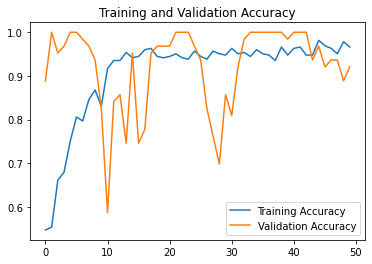

In [28]:
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

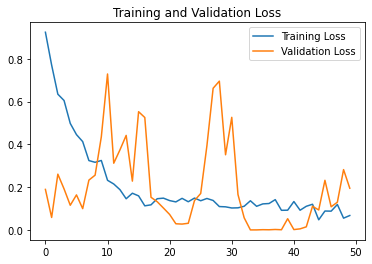

In [29]:
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()